In [41]:
from asyncio.constants import SENDFILE_FALLBACK_READBUFFER_SIZE
from multiprocessing import pool
import pandas as pd
import numpy as np

In [42]:
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [12,6]
sns.set(style="darkgrid")

pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

## Funções que serão necessárias durante o código


In [43]:
def unique(list1):
     
    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))

    if(all(isinstance(n, not str)) for n in unique_list):
        
        unique_list = [item for item in unique_list if not(pd.isnull(item)) == True]
    
    return unique_list, len(unique_list)

def counterElements(lista):

    auxLista, _ = unique(lista)

    dicio = dict.fromkeys(auxLista, 0)
    dicio['NaN'] = 0

    for i, value in enumerate(auxLista):
        
        counter = 0

        for j in range(len(lista)):

            if lista[j] == auxLista[i]:

                counter += 1
    
        dicio[value] = counter

    dicio['NaN'] = lista.isna().sum()

    return dicio

def createColumnsWNaN():

    totalSum = 0
    columnsWNaN = []

    for column in corrList:
        
        nullElements = X[column].isnull().sum()

        if(nullElements):
            columnsWNaN.append(column)
            totalSum+=1

    if(totalSum > 1):

        print('There are {} relevant columns in with one or more "NaN" as values: {}'.format(totalSum, columnsWNaN))

    else:
        print('There is 1 relevant column in with one or more "NaN" as values: {}'.format(columnsWNaN))

    return columnsWNaN

def createPercentageOfMissingValues(lista = createColumnsWNaN()):
    percentColumnWNaN = {}
    totalColumnWNan = {}

    for column in lista:

        percentColumnWNaN[column] = (X[column].isnull().sum() / len(X[column])) * 100
        totalColumnWNan[column] = X[column].isnull().sum()

    dfPercent = pd.DataFrame(list(percentColumnWNaN.items()), columns = ['Feature', 'Faltantes %'])

    dfPercent['Faltantes Total'] = dfPercent['Feature'].map(totalColumnWNan)

    dfPercent = dfPercent.sort_values(by = ['Faltantes %'], ascending = False)

    return dfPercent

There are 2 relevant columns in with one or more "NaN" as values: ['MasVnrArea', 'GarageYrBlt']


In [44]:
X = pd.read_csv('train.csv')

In [45]:
train_ID = X['Id']

X.drop('Id', axis = 1, inplace = True)

## Informações da saída do dataset 

Com essas informações, pode-se montar o histograma para a análise dos dados. Algo importante para se ter em conta é que não existe o valor 0 nesse *output*, que atrapalharia o modelo regressor, nada que não pudesse ser tratado, como é explicado em [*Medium, Zero-Inflated Regression*](https://towardsdatascience.com/zero-inflated-regression-c7dfc656d8af).

In [46]:
print(X['SalePrice'].describe())

count     1460.00
mean    180921.20
std      79442.50
min      34900.00
25%     129975.00
50%     163000.00
75%     214000.00
max     755000.00
Name: SalePrice, dtype: float64


## Criando o histograma dos dados
Com o histograma dos dados gerado, é possível analisar melhor o formato dos dados. Nota-se que a distribuição dos mesmos foge da distribuição normal, tendo uma assimetria positiva, indicando que existem mais elementos maiores que o pico da função de distribuição. O valor positivo da curtose indica uma curva leptocúrtica, que representa o quão fácil é encontrar elementos do *dataset* que fogem da média.

Assimetria: 1.8828757597682129
Curtose: 6.536281860064529


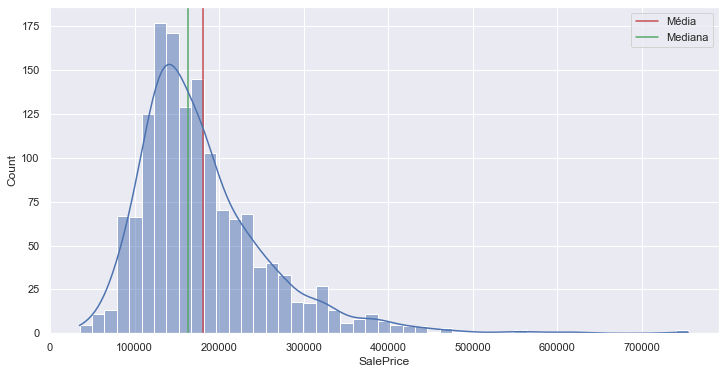

In [47]:
mean = X['SalePrice'].mean()
median = X['SalePrice'].median()

plt.axvline(mean, color = 'r', linestyle = '-')
plt.axvline(median, color = 'g', linestyle = '-')

sns.histplot(X['SalePrice'], kde = True)

print('Assimetria: {}'.format(X['SalePrice'].skew()))

print('Curtose: {}'.format(X['SalePrice'].kurt()))

plt.legend({'Média': mean,'Mediana': median})

## Criando um *heatmap* 
Com o *heatmap*, pode-se analisar como as categorias se relacionam. Quanto mais próximo do vermelho, mais a correlação de categorias é diretamente proporcional. De outra forma, as correlações próximas do azul escuro representam catgegorias inversamente proporcionais se relacionando. Correlações próximas do cinza representam como as categorias não se influenciam. A categoria-alvo que o modelo predirá é *SalePrice*, que representa o valor de venda de uma casa.  

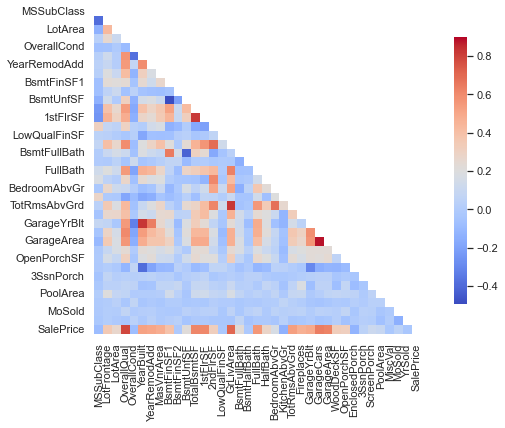

In [48]:
correlation = X.corr()

mask = np.zeros_like(correlation)

mask[np.triu_indices_from(mask)] = True

with sns.axes_style('white'):

    f, ax = plt.subplots()

    sns.heatmap(correlation, mask = mask, ax = ax, cbar_kws = {'shrink' : .82},
                vmax = .9, cmap = 'coolwarm', square = True)

Pode-se ver que algumas correlações com *SalePrice* estão em vermelho, indicando que são as categorias mais relevantes para se considerar antes de utilizar o modelo regressor. É, então, selecionado todas as categorias que se correlacionam com *SalePrice* com um valor maior que 0.4.

In [49]:
feature = list(correlation.columns)

values = correlation.values

corrList = []

for i, val in enumerate(values[36]):

    if(val > 0.4 and feature[i] != 'SalePrice'):

        corrList.append(feature[i])
        print('SalePrice and {} correlates with value {}.'.format(feature[i], "{:.2f}".format(val)))

print('Total features related to SalePrice: {}'.format(len(corrList)))

SalePrice and OverallQual correlates with value 0.79.
SalePrice and YearBuilt correlates with value 0.52.
SalePrice and YearRemodAdd correlates with value 0.51.
SalePrice and MasVnrArea correlates with value 0.48.
SalePrice and TotalBsmtSF correlates with value 0.61.
SalePrice and 1stFlrSF correlates with value 0.61.
SalePrice and GrLivArea correlates with value 0.71.
SalePrice and FullBath correlates with value 0.56.
SalePrice and TotRmsAbvGrd correlates with value 0.53.
SalePrice and Fireplaces correlates with value 0.47.
SalePrice and GarageYrBlt correlates with value 0.49.
SalePrice and GarageCars correlates with value 0.64.
SalePrice and GarageArea correlates with value 0.62.
Total features related to SalePrice: 13


Dessas categorias, porém, existem 2 que contém valores não preenchidos, que podem causar problemas para o modelo regressor prever os resultados. 

In [50]:
columns = createColumnsWNaN()

for i in columns:

    unique_list, size = unique(X[i])

    unique_list.append(np.nan)
    size += 1

    #print('{}: {}, {}'.format(i, size, unique_list))

There are 2 relevant columns in with one or more "NaN" as values: ['MasVnrArea', 'GarageYrBlt']


Para avaliar o quão impactante pode ser essa falta de valores não preenchidos, checa-se quantos desses valores não estão preenchidos

In [52]:
dfPercent = createPercentageOfMissingValues()

print(dfPercent)

       Feature  Faltantes %  Faltantes Total
1  GarageYrBlt         5.55               81
0   MasVnrArea         0.55                8


Text(0.5, 1.0, 'Porcentagem de valores faltantes por Feature')

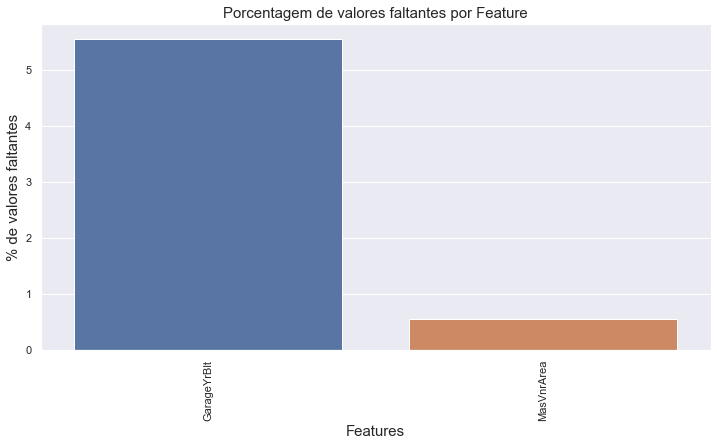

In [58]:
sns.barplot(x = dfPercent['Feature'], y = dfPercent['Faltantes %'])
plt.xticks(rotation = '90')
plt.xlabel('Features', fontsize = 15)
plt.ylabel('% de valores faltantes', fontsize = 15)
plt.title('Porcentagem de valores faltantes por Feature', fontsize = 15)

A maior porcentagem de valores faltantes equivale a 5% dos valores, uma quantidade não muito expressiva. Existem alguns modelos que podem ser utilizados para problemas de regressão que permitem valores não preenchidos, como, por exemplo, o *Random Forest*. Por enquanto, esses valores não preenchidos não causarão problemas.

In [36]:
updatedCorrelation = corrList

updatedCorrelation.append('SalePrice')

Com as correlações, pode-se ver melhor a forma em que cada categoria se relaciona com *SalePrice*. 

<function matplotlib.pyplot.show(close=None, block=None)>

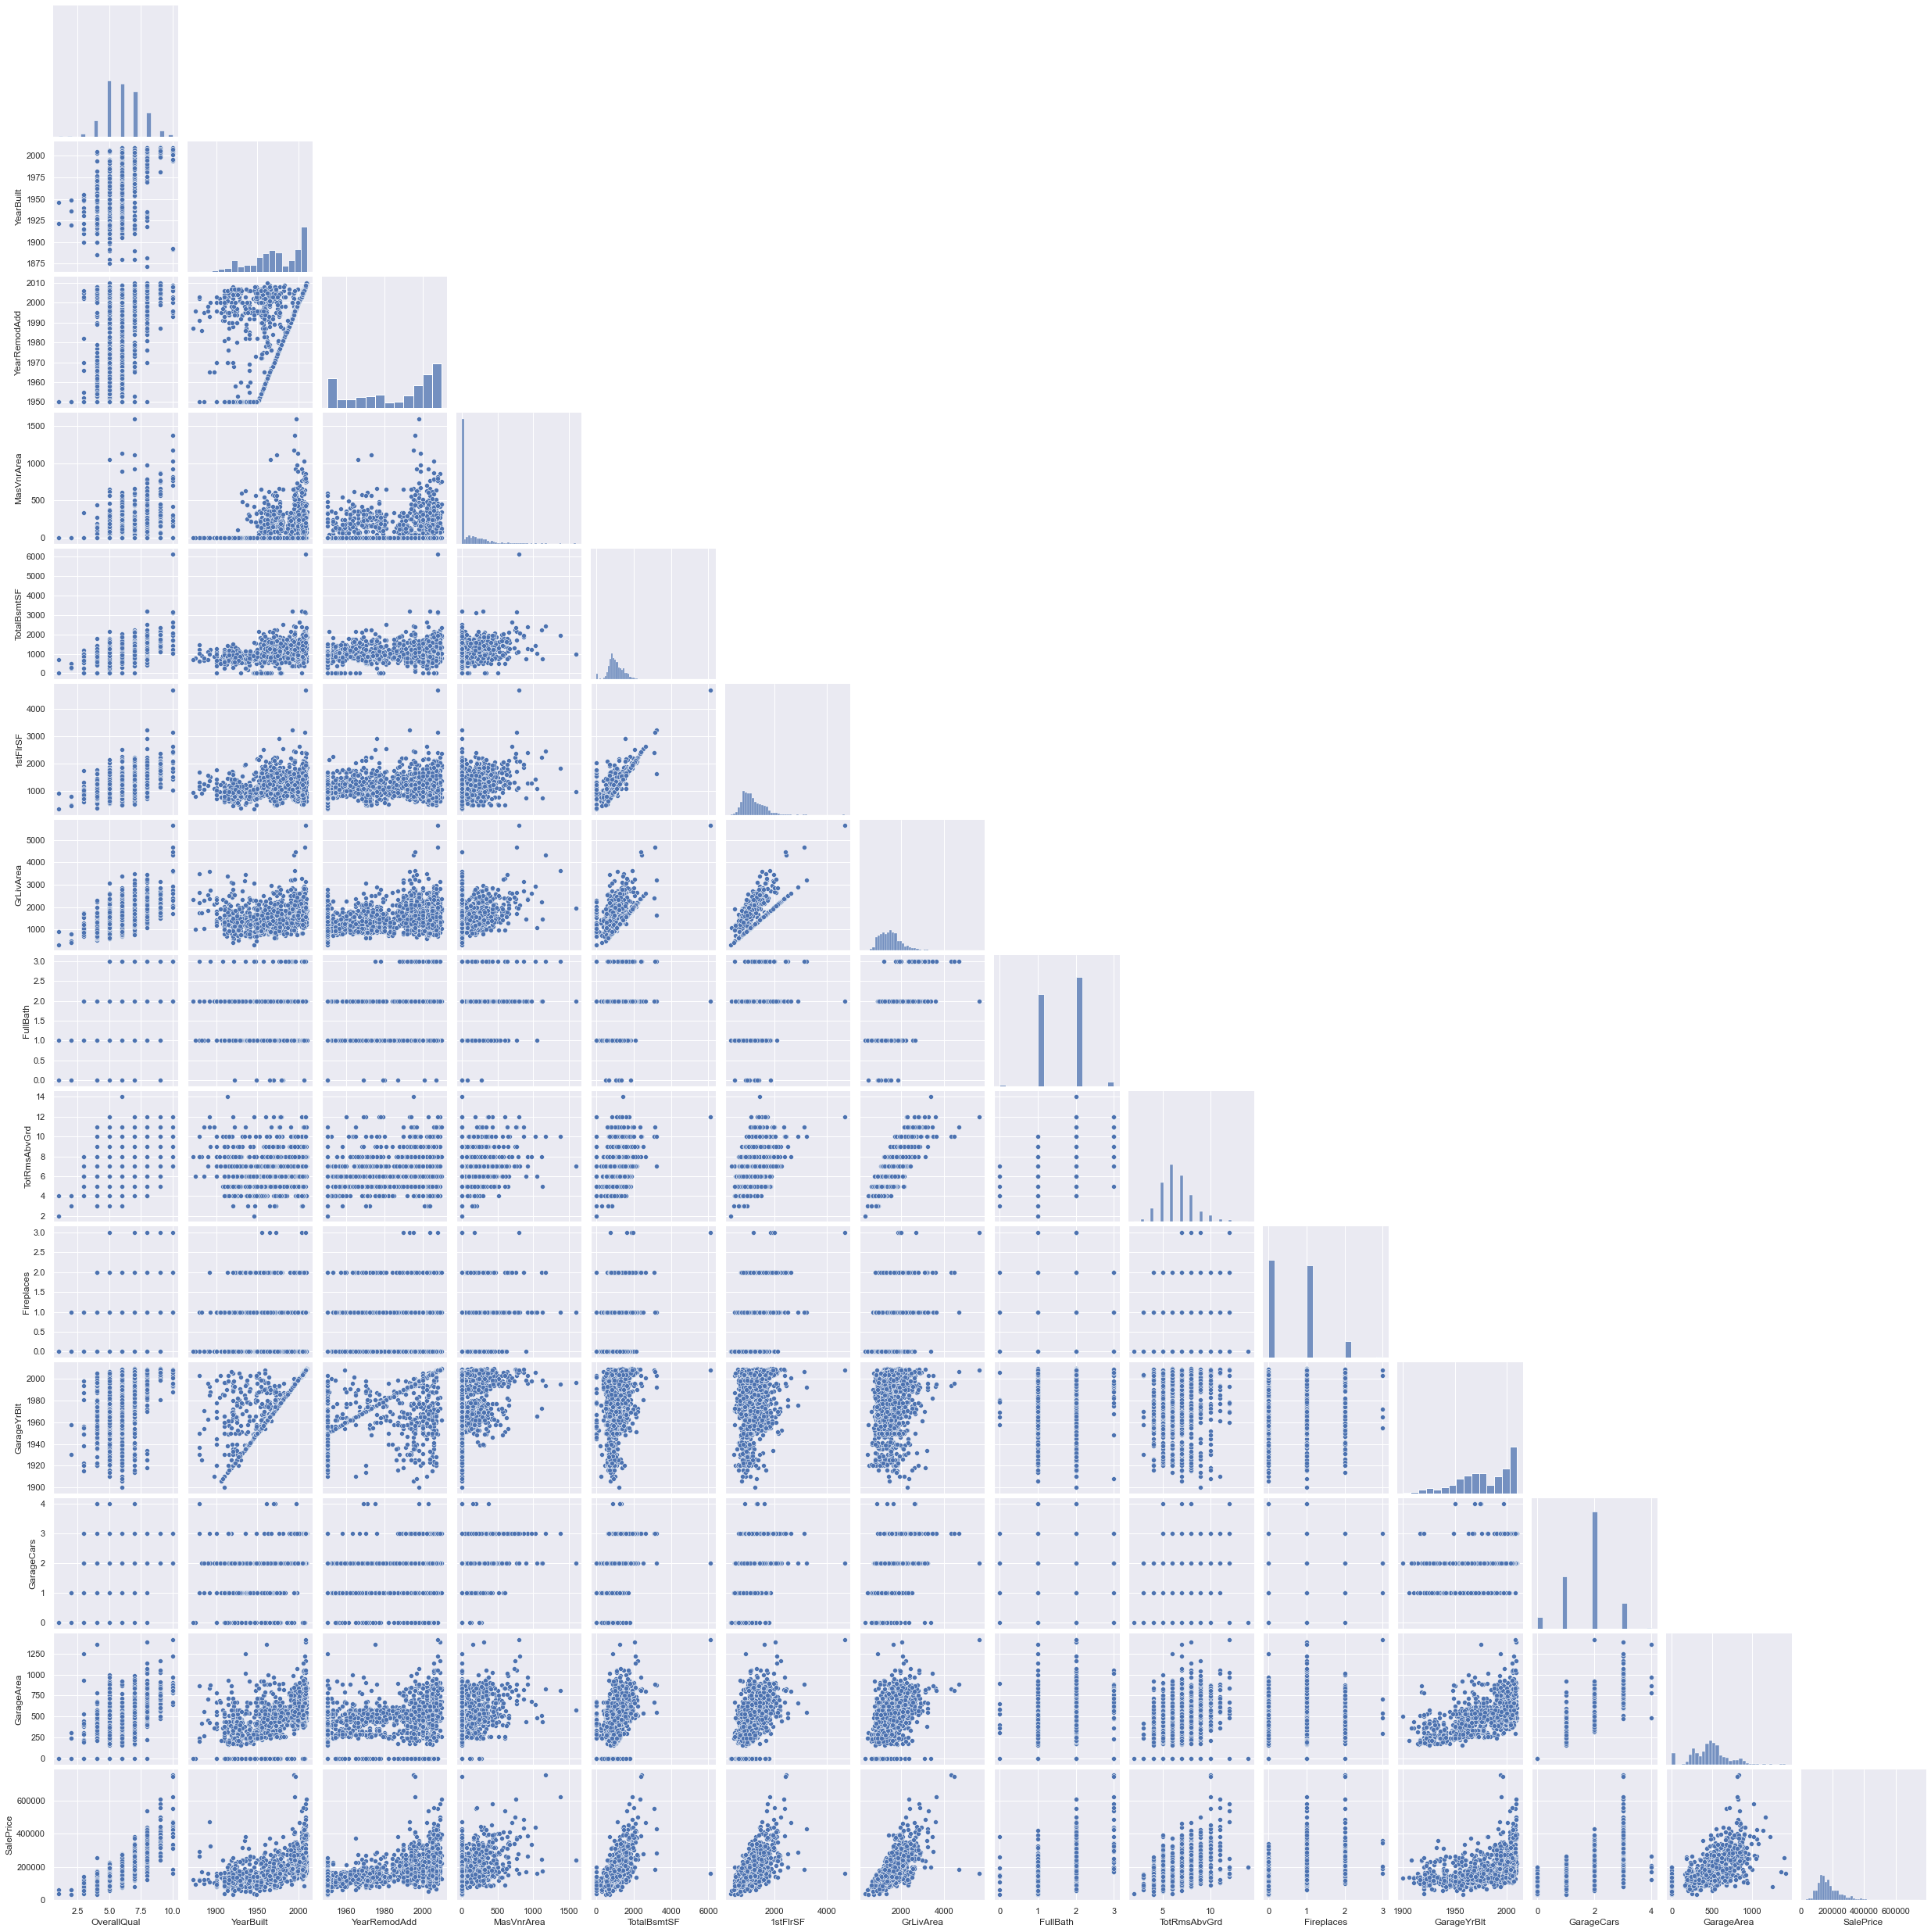

In [37]:
sns.set()

sns.pairplot(X[updatedCorrelation], height = 2.5, corner = True)

plt.show

Algumas categorias são interessantes de analisar: *1stFlrSF* se relaciona com *SalePrice* formando algo como uma exponencial, indicando que, quanto maior a área do primeiro andar, mais caro uma casa pode ser vendida, crescendo de maneira abrupta a partir de um valor. *GrLivArea* e *TotalBsmtSF* se comportam de maneira parecida. 

Já *YearBuilt*, *YearRemodAdd*, *GarageYrBlt* e *GarageArea* se comportam de maneira similar à uma fórmula linear, mantendo um crescimento constante em relação ao aumento do preço da casa. 

As características categóricas (*OverallQual*, *FullBath*, *TotRmsAbvGrd*, *Fireplaces* e *GarageCars*) tem um crescimento mais linear.

In [ ]:
#X = X[X.GarageYrBlt.notnull()]

#print(unique(X['GarageYrBlt']))